
___
# Conducting a Parameter Estimation
___

Author: Savannah Sakhai

For this demonstration, we will be going through how to set up a parameter estimation using the pyomo tool ***parmest***. This simple case study aims to develop an empirical equation for the vapor pressure of a NaCl solution over a range of temperature and salt mass fractions.

### Step 0: Imports

In [2]:
import pandas as pd # to create a pandas dataframe to organize the data
import numpy as np # to manipulate the data into a usable format
import pyomo.contrib.parmest.parmest as parmest # to perform the parameter estimation
import pyomo.environ as pyo # to create a pyomo model
import matplotlib.pyplot as plt # to plot the results

### Step 1: Gather the data

In [3]:
# data obtained using PhreeqC
# read in csv file to pd.dataframe
data = pd.read_csv(
    'P_sat_Data.csv',
    header=None,
)

print((data.to_markdown()))

|    |        0 |          1 |           2 |          3 |          4 |          5 |          6 |         7 |         8 |         9 |        10 |         11 |        12 |        13 |        14 |        15 |        16 |
|---:|---------:|-----------:|------------:|-----------:|-----------:|-----------:|-----------:|----------:|----------:|----------:|----------:|-----------:|----------:|----------:|----------:|----------:|----------:|
|  0 | nan      | 5          | 10          | 20         | 30         | 40         | 50         | 60        | 70        | 80        | 90        | 100        | 110       | 120       | 130       | 140       | 150       |
|  1 |  35      | 0.00854753 |  0.0119806  |  0.0226642 |  0.0409391 |  0.070926  |  0.118314  |  0.190684 |  0.297821 |  0.451976 |  0.66808  |   0.963854 |   1.36014 |   1.88027 |   2.55023 |   3.39834 |   4.45478 |
|  2 |  51.0714 | 0.00844669 |  0.011838   |  0.0223909 |  0.0404411 |  0.0700583 |  0.116862  |  0.188342 |  0.294164 |  0.4464


### Step 2: Prepare the data
*How does parmest need the data to be formatted?*


- **Pandas Dataframe:** each column is an observed quantity (temperature, concentration, vapor pressure, etc.), each row is a distinct scenario (25, 0.02, 31.33)

**Other options:**
- **List of Pandas Dataframe:** each entry of the list is a distinct scenario, each dataframe an observed quantity
- **List of dictionaries:** each entry of the list is a distinct scenario, each key an observed quantity 
- **List of json file names:** each entry of the list contains a json file with the distinct scenario (for large datasets in parallel computing)

In [4]:
def get_formatted_data(data):
    # convert dataframe to numpy array for the manipulations
    npdata = data.to_numpy()

    # obtain input variables (salt g/kg water, temperature C)
    c = npdata[1:, 0]
    T = npdata[0, 1:]

    # repeat each value of temperature for the number of mass fraction entries
    T_col = np.repeat(T, len(c)).T +273 #celsius to kelvin

    # repeat the set of mass fraction entries for the number of temperature entries
    c_col = np.tile(c, len(T)).T /1000  #g/kg water to mass frac 

    # take the output table and create a column
    output_data = npdata[1:, 1:].T.reshape(-1) * 101325 #atm to Pa

    # compile into one table where each column is a different observed quantity
    total_data = np.column_stack([c_col, T_col, output_data])

    # redefine as a pandas dataframe with named columns
    data = pd.DataFrame(total_data,
                        columns=['Comp', 'Temp', 'PropData'],
                        )

    # delete all rows when column 'PropData' has a value of 0 (scenarios without measured property data)
    index_NA = data[(data['PropData'] == 0)].index
    data.drop(index_NA, inplace=True)

    return data
    

In [5]:
data_formatted = get_formatted_data(data) 
print(data_formatted.to_markdown())

|     |      Comp |   Temp |   PropData |
|----:|----------:|-------:|-----------:|
|   0 | 0.035     |    278 |    866.079 |
|   1 | 0.0510714 |    278 |    855.861 |
|   2 | 0.0671429 |    278 |    845.434 |
|   3 | 0.0832143 |    278 |    834.74  |
|   4 | 0.0992857 |    278 |    823.735 |
|   5 | 0.115357  |    278 |    812.381 |
|   6 | 0.131429  |    278 |    800.649 |
|   7 | 0.1475    |    278 |    788.517 |
|   8 | 0.163571  |    278 |    775.968 |
|   9 | 0.179643  |    278 |    762.991 |
|  10 | 0.195714  |    278 |    749.577 |
|  11 | 0.211786  |    278 |    735.724 |
|  12 | 0.227857  |    278 |    721.433 |
|  13 | 0.243929  |    278 |    706.709 |
|  14 | 0.26      |    278 |    691.56  |
|  15 | 0.035     |    283 |   1213.93  |
|  16 | 0.0510714 |    283 |   1199.49  |
|  17 | 0.0671429 |    283 |   1184.72  |
|  18 | 0.0832143 |    283 |   1169.56  |
|  19 | 0.0992857 |    283 |   1153.96  |
|  20 | 0.115357  |    283 |   1137.86  |
|  21 | 0.131429  |    283 |   112

### Step 3: Propose a model
*What equation are parameters being fit to?*

***Parmest*** requires a "model function" to be defined that takes in the data and returns a Pyomo model.

    Set up the Pyomo model defining:
    - Pyomo Vars or Params for each paramter (or 'theta') to be estimated
    - the model equation (a function of the observed data i.e. temperature, mass fraction)

 

For this example, the model we are proposing is:

$$
 (a_0 + a_1*x + a_2*x^2 + a_3*x^3+ a_4*x^4)
$$
$$
+ (b_0 + b_1*x + b_2*x^2 + b_3*x^3+ b_4*x^4)*T
$$
$$
+ (c_0 + c_1*x + c_2*x^2 + c_3*x^3+ c_4*x^4)*T^2
$$
$$
+ (d_0 + d_1*x + d_2*x^2 + d_3*x^3+ d_4*x^4)*T^3
$$
$$
+ (e_0 + e_1*x + e_2*x^2 + e_3*x^3 + e_4*x^4)*T^4 
$$

*(This was an equation found in [literature](https://www.sciencedirect.com/science/article/pii/S0011916403900683) used when fitting Pitzer NaCl Data).*

In [6]:
def model_function(data):
    m = pyo.ConcreteModel()

    # define variables for the estimated parameters
    m.a0 = pyo.Var(initialize=1)
    m.a1 = pyo.Var(initialize=1)
    m.a2 = pyo.Var(initialize=1)
    m.a3 = pyo.Var(initialize=1)
    m.a4 = pyo.Var(initialize=1)

    m.b0 = pyo.Var(initialize=1)
    m.b1 = pyo.Var(initialize=1)
    m.b2 = pyo.Var(initialize=1)
    m.b3 = pyo.Var(initialize=1)
    m.b4 = pyo.Var(initialize=1)

    m.c0 = pyo.Var(initialize=1)
    m.c1 = pyo.Var(initialize=1)
    m.c2 = pyo.Var(initialize=1)
    m.c3 = pyo.Var(initialize=1)
    m.c4 = pyo.Var(initialize=1)

    m.d0 = pyo.Var(initialize=1)
    m.d1 = pyo.Var(initialize=1)
    m.d2 = pyo.Var(initialize=1)
    m.d3 = pyo.Var(initialize=1)
    m.d4 = pyo.Var(initialize=1)

    m.e0 = pyo.Var(initialize=1)
    m.e1 = pyo.Var(initialize=1)
    m.e2 = pyo.Var(initialize=1)
    m.e3 = pyo.Var(initialize=1)
    m.e4 = pyo.Var(initialize=1)

    # define the model/equation
    def prop_rule(m, x, T):
        expr = ((m.a0 + m.a1*x + m.a2*x**2 + m.a3*x**3+ m.a4*x**4)
                + (m.b0 + m.b1*x + m.b2*x**2 + m.b3*x**3+ m.b4*x**4)*T
                + (m.c0 + m.c1*x + m.c2*x**2 + m.c3*x**3+ m.c4*x**4)*T**2
                + (m.d0 + m.d1*x + m.d2*x**2 + m.d3*x**3+ m.d4*x**4)*T**3
                + (m.e0 + m.e1 * x + m.e2 * x ** 2 + m.e3 * x ** 3 + m.e4 * x ** 4) * T ** 4
        )
        return expr

    m.prop_func = pyo.Expression(data.Comp, data.Temp, rule=prop_rule)

    def SSE_rule(m):
        return sum(
            (data.PropData[i] - m.prop_func[data.Comp[i], data.Temp[i]]) ** 2 for i in data.index
        )
    
    m.SSE = pyo.Objective(rule=SSE_rule, sense=pyo.minimize)

    return m


### Step 4: Create a list of theta names

The variables to be estimated by parmest must be given as a list of strings of the variable names as they are defined in the model_function. 

In [7]:
# varaibles from model to be estimated
# required format: list with strings of param/var names
theta_names = ['a0', 'a1', 'a2', 'a3', 'a4',
               'b0', 'b1', 'b2', 'b3', 'b4',
               'c0', 'c1', 'c2', 'c3', 'c4',
               'd0', 'd1', 'd2', 'd3', 'd4',
               'e0', 'e1', 'e2', 'e3', 'e4']

### Step 5: Define an objective function

Now, we must define an objective function for the parameter estimation. This is the deviation between the observation and the prediction typically chosen to be the sum of squared errors.

$$
\sum_{i=0}^n (observation_i - prediction_i)^2 
$$


In [8]:
# Sum of Squared Errors function
def objective_function(m,data):
    
    expr = sum(((data.PropData[i] - m.prop_func[data.Comp[i], data.Temp[i]]) ** 2) for i in data.index)

    return expr

### Step 6: Solve the parameter estimation problem

Now, we have everything we need for parmest to solve the parameter estimation problem: 

    - model_function
    - data_formatted
    - theta_names
    - objective_function


#### Step 6a: Set up the problem

Set up the parameter estimation problem by creating an instance of the parmest 'Estimator' object and feed it the required inputs.

In [9]:
# create an instance of the parmest estimator
pest = parmest.Estimator(model_function, data_formatted, theta_names, objective_function, tee=False)

#### Step 6b: Solve the parameter estimation problem 

Solve the parameter estimation problem by calling theta_est. This will use the entire data set to perform the parameter estimation. 

There are additional options for solving and testing. Further details can be found in the [parmest documentation](https://pyomo.readthedocs.io/en/stable/contributed_packages/parmest/index.html#index-of-parmest-documentation).

In [10]:
# solve the parameter estimation problem
obj, theta = pest.theta_est()

# display results
print('theta:\n', theta)

theta:
 a0     -112.604935
a1       21.674330
a2        9.084923
a3        3.186679
a4        1.549862
b0   -15567.585181
b1      931.907521
b2      544.433719
b3      158.726511
b4       41.833958
c0      153.695738
c1      -19.742926
c2      -21.314709
c3       20.771367
c4       11.991121
d0       -0.507158
d1        0.099333
d2        0.114492
d3       -0.111611
d4       -0.117338
e0        0.000560
e1       -0.000146
e2       -0.000168
e3        0.000146
e4        0.000240
dtype: float64


### Step 7: Plot results

Finally, we can visualize the results using ***matplotlib*** to create a 3D plot of the data and the parameter estimatation fit. 

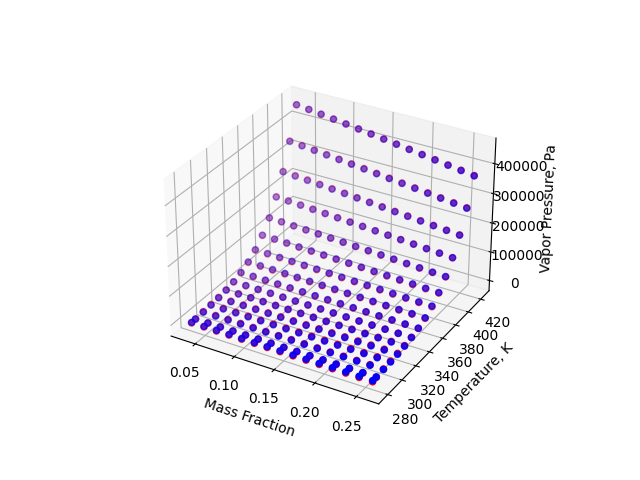

In [11]:
# define a function for the model with estimated thetas
def est(x, T):
    est = ((theta['a0'] + theta['a1']*x + theta['a2']*x**2 + theta['a3']*x**3 + theta['a4']*x**4)
        + (theta['b0'] + theta['b1']*x + theta['b2']*x**2 + theta['b3']*x**3 + theta['b4']*x**4)*T
        + (theta['c0'] + theta['c1']*x + theta['c2']*x**2 + theta['c3']*x**3 + theta['c4']*x**4)*T**2
        + (theta['d0'] + theta['d1']*x + theta['d2']*x**2 + theta['d3']*x**3 + theta['d4']*x**4)*T**3
        + (theta['e0'] + theta['e1']*x + theta['e2']*x**2 + theta['e3']*x**3 + theta['e4']*x**4)*T**4
)
    return est

# plot the results
%matplotlib ipympl 
# makes figure interactive
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(data_formatted.Comp, data_formatted.Temp, data_formatted.PropData, color='b') # experimental data
ax.scatter(data_formatted.Comp, data_formatted.Temp, est(data_formatted.Comp,data_formatted.Temp), color='r') # parmest fit
ax.set_xlabel('Mass Fraction')
ax.set_ylabel('Temperature, K')
ax.set_zlabel('Vapor Pressure, Pa')
plt.show()